In [1]:
import math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import japanize_matplotlib
pd.options.display.max_columns=50

/Users/naoto.shimakoshi/github/kaggle/kaggle-walmart/.venv/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## version 1 (simpleにターゲットの統計値のみ)

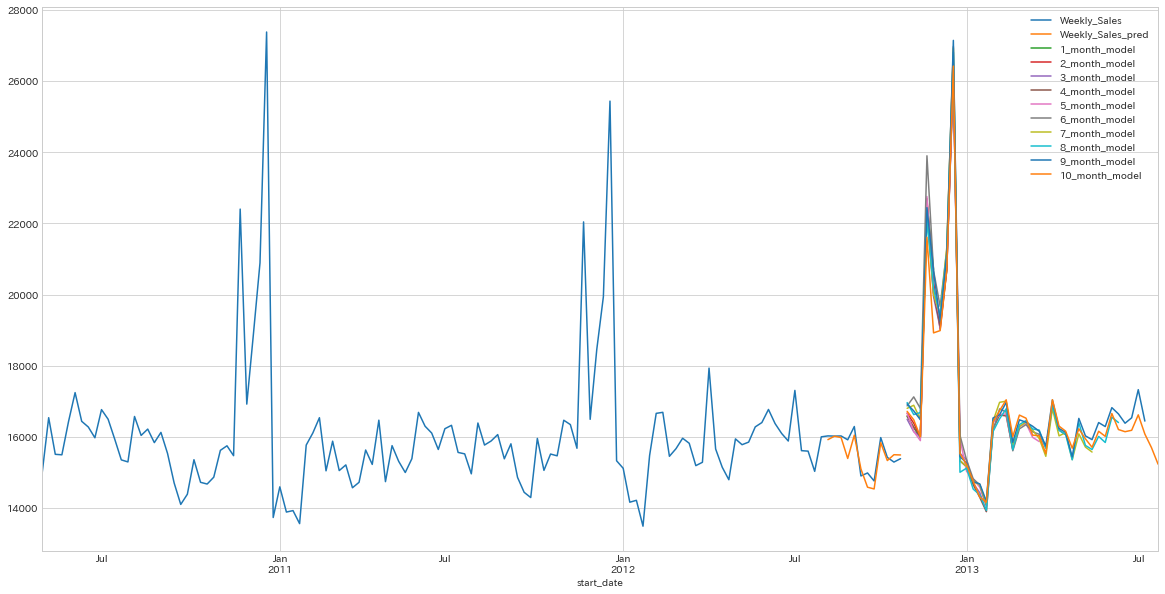

In [2]:
train_df = pd.read_pickle(f'../output/add_lag_feature/result/1month_train.pkl')[
    ['Store', 'Dept', 'start_date', 'Weekly_Sales', 'Weekly_Sales_pred_fold0', 'Weekly_Sales_pred_fold1', 'Weekly_Sales_pred_fold2']
]
train_df['Weekly_Sales_pred'] = train_df[[col for col in train_df.columns if 'pred' in col]].mean(1)
ax = train_df.groupby('start_date')[['Weekly_Sales', 'Weekly_Sales_pred']].mean().plot(figsize=(20, 10))
result_df = pd.read_pickle(f'../output/baseline/result/10month_test.pkl')[['Store', 'Dept', 'start_date']]
for i in range(1, 11):
    test_df = pd.read_pickle(f'../output/baseline/result/{i}month_test.pkl')[['Store', 'Dept', 'start_date', 'Weekly_Sales']]
    test_df.groupby('start_date')['Weekly_Sales'].mean().plot(ax=ax, label=f'{i}_month_model')
    test_df = test_df.rename(columns={'Weekly_Sales': f'Weekly_Sales_{i}month'})
    result_df = result_df.merge(test_df, on=['Store', 'Dept', 'start_date'], how='left')
ax.legend()

- 周期性はある程度捕らえられてそう 

In [3]:
result_df['id'] = result_df['Store'].astype('str') + '_' + result_df['Dept'].astype('str')+ '_' + result_df['start_date'].astype('str')

In [4]:
# COALESCE的にNULLを埋めてく (あまりよくなかったのでコメントアウト)
# result_df['Weekly_Sales'] = np.nan
# for i in range(1, 11):
#     result_df['Weekly_Sales'].fillna(result_df[f'Weekly_Sales_{i}month'], inplace=True)
# result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline.csv', index=False)

In [5]:
# 全部の予測を平均化
result_df['null_count'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].notnull().sum(1)
result_df['Weekly_Sales'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].sum(1) / result_df['null_count']
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_mean.csv', index=False)

### 移動平均 (あまりよくなかった)

In [6]:
result_df = pd.concat([train_df, result_df], axis=0)
result_df = result_df.sort_values(['Store', "Dept", "start_date"]).reset_index(drop=True)

In [7]:
result_df['Weekly_Sales_rolling_mean'] = result_df.groupby(['Store', "Dept"])['Weekly_Sales'].rolling(2, center=True).mean().values

In [8]:
result_df['Weekly_Sales_rolling_mean'].fillna(result_df['Weekly_Sales'], inplace=True)

In [9]:
result_df['Weekly_Sales'] = result_df['Weekly_Sales_rolling_mean']

In [10]:
result_df.query('start_date >= "2012-11-01"')[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_rolliing_mean.csv', index=False)

<AxesSubplot:xlabel='start_date'>

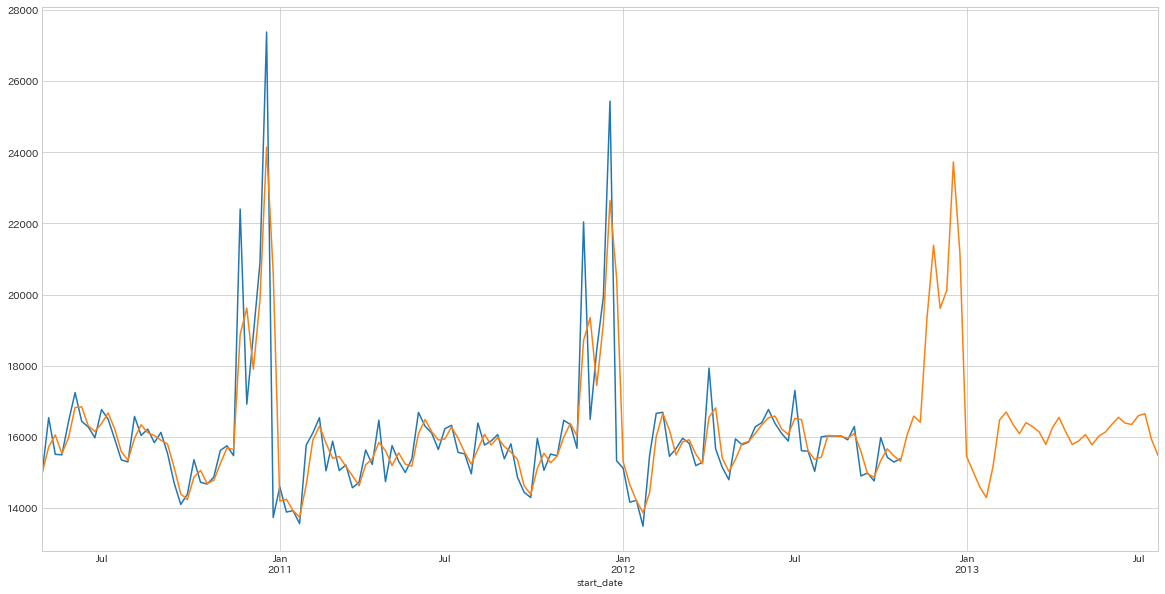

In [11]:
train_df = pd.read_pickle(f'../output/baseline/result/{i}month_train.pkl')[['Store', 'Dept', 'start_date', 'Weekly_Sales']]
ax = train_df.groupby('start_date')['Weekly_Sales'].mean().plot(figsize=(20, 10))
result_df.groupby('start_date')['Weekly_Sales'].mean().plot(ax=ax, label=f'{i}_month_model')

## version 2 (Lag特徴量を追加)

In [12]:
model_name = 'add_lag_feature'

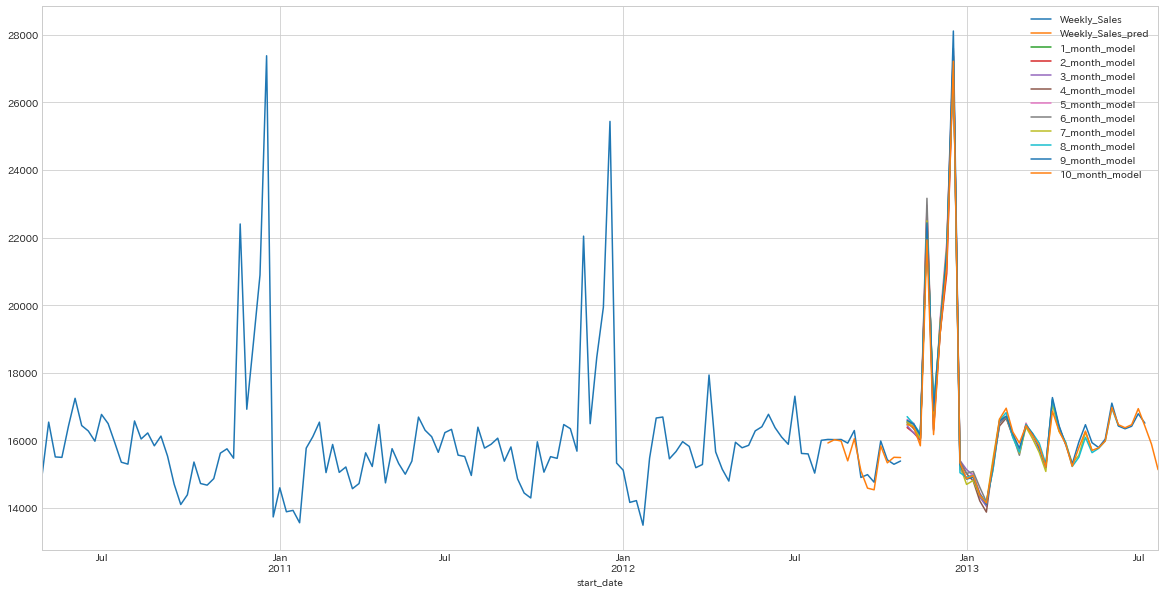

In [13]:
train_df = pd.read_pickle(f'../output/{model_name}/result/1month_train.pkl')[
    ['Store', 'Dept', 'start_date', 'Weekly_Sales', 'Weekly_Sales_pred_fold0', 'Weekly_Sales_pred_fold1', 'Weekly_Sales_pred_fold2']
]
train_df['Weekly_Sales_pred'] = train_df[[col for col in train_df.columns if 'pred' in col]].mean(1)
ax = train_df.groupby('start_date')[['Weekly_Sales', 'Weekly_Sales_pred']].mean().plot(figsize=(20, 10))
result_df = pd.read_pickle(f'../output/{model_name}/result/10month_test.pkl')[['Store', 'Dept', 'start_date']]
for i in range(1, 11):
    test_df = pd.read_pickle(f'../output/{model_name}/result/{i}month_test.pkl')[['Store', 'Dept', 'start_date', 'Weekly_Sales']]
    test_df.groupby('start_date')['Weekly_Sales'].mean().plot(ax=ax, label=f'{i}_month_model')
    test_df = test_df.rename(columns={'Weekly_Sales': f'Weekly_Sales_{i}month'})
    result_df = result_df.merge(test_df, on=['Store', 'Dept', 'start_date'], how='left')
ax.legend()

- 分散がv1より抑えられている
  - 統計値が強いことからも分かるが、1年前の特徴は重要

In [14]:
result_df['id'] = result_df['Store'].astype('str') + '_' + result_df['Dept'].astype('str')+ '_' + result_df['start_date'].astype('str')

In [15]:
result_df['null_count'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].notnull().sum(1)
result_df['Weekly_Sales'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].sum(1) / result_df['null_count']
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_mean_v2.csv', index=False)

### postprocess

In [16]:
def postprocess(df):
    """
    12月最終週とクリスマス週の予測値を分割
    """
    df['month'] = df['start_date'].dt.month

    df = df.sort_values(['Store', "Dept", "start_date"]).reset_index(drop=True)

    df['Weekly_Sales_lead1'] = df.groupby(["Store", "Dept"])['Weekly_Sales'].shift(-1)
    df['month_lead1'] = df.groupby(["Store", "Dept"])['month'].shift(-1)
    df['Weekly_Sales_lag1'] = df.groupby(["Store", "Dept"])['Weekly_Sales'].shift(1)
    df['month_lag1'] = df.groupby(["Store", "Dept"])['month'].shift(1)
    # クリスマス週で一週後の実績値が存在するものに対してPP
    index = df.query('start_date == "2012-12-21" & month_lead1=="2012-12-28" & Weekly_Sales_lead1==Weekly_Sales_lead1').index
    df.loc[index, 'Weekly_Sales'] = (df.loc[index, 'Weekly_Sales'] + df.loc[index, 'Weekly_Sales_lead1']) / 14 * 6
    # 年末週で一週前の実績値が存在するものに対してPP
    index = df.query('start_date == "2012-12-28" & month_lag1=="2012-12-21"& Weekly_Sales_lag1==Weekly_Sales_lag1').index
    df.loc[index, 'Weekly_Sales'] = (df.loc[index, 'Weekly_Sales'] + df.loc[index, 'Weekly_Sales_lag1']) / 14 * 8
    return df

def postprocess_v2(df):
    """
    12月最終週とクリスマス週の予測値を調整
    """
    index = df.query('start_date == "2012-12-21"').index
    df.loc[index, 'Weekly_Sales'] = df.loc[index, 'Weekly_Sales'] / 7 * 6
    # 年末週で一週前の実績値が存在するものに対してPP
    index = df.query('start_date == "2012-12-28"').index
    df.loc[index, 'Weekly_Sales'] = df.loc[index, 'Weekly_Sales'] / 7 * 8
    return df

In [17]:
result_df = postprocess_v2(result_df)

In [18]:
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_mean_v2_pp.csv', index=False)

### statsとアンサンブル

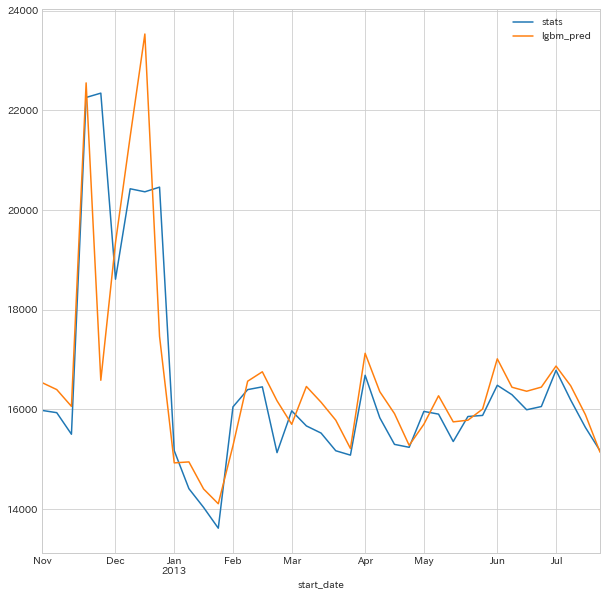

In [19]:
stats_df = pd.read_csv(f'../output/stats.csv')
stats_df['start_date'] = pd.to_datetime(stats_df['id'].apply(lambda x: x.split('_')[-1]), infer_datetime_format=True)
ax = stats_df.groupby('start_date')['Weekly_Sales'].mean().plot(figsize=(10, 10), label='stats')
result_df.groupby('start_date')['Weekly_Sales'].mean().plot(ax=ax, label='lgbm_pred')
ax.legend()

In [20]:
result_df = result_df.sort_values('id').reset_index(drop=True)
stats_df = stats_df.sort_values('id').reset_index(drop=True)
result_df['Weekly_Sales'] = (result_df['Weekly_Sales'] + stats_df['Weekly_Sales']) / 2

In [21]:
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_mean_v2_stats_ens_pp.csv', index=False)

## version2 (Ridge回帰)

In [22]:
model_name = 'add_lag_feature_ridge'

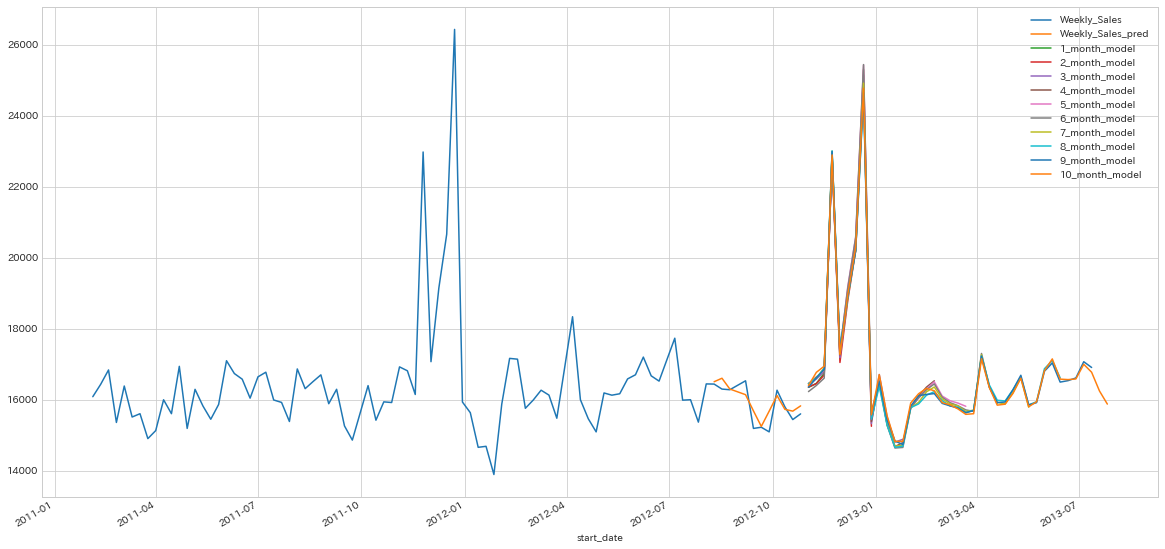

In [23]:
train_df = pd.read_pickle(f'../output/{model_name}/result/1month_train.pkl')[
    ['Store', 'Dept', 'start_date', 'Weekly_Sales', 'Weekly_Sales_pred_fold0', 'Weekly_Sales_pred_fold1', 'Weekly_Sales_pred_fold2']
]
train_df['Weekly_Sales_pred'] = train_df[[col for col in train_df.columns if 'pred' in col]].mean(1)
ax = train_df.groupby('start_date')[['Weekly_Sales', 'Weekly_Sales_pred']].mean().plot(figsize=(20, 10))
result_df = pd.read_pickle(f'../output/{model_name}/result/10month_test.pkl')[['Store', 'Dept', 'start_date']]
for i in range(1, 11):
    test_df = pd.read_pickle(f'../output/{model_name}/result/{i}month_test.pkl')[['Store', 'Dept', 'start_date', 'Weekly_Sales']]
    test_df.groupby('start_date')['Weekly_Sales'].mean().plot(ax=ax, label=f'{i}_month_model')
    test_df = test_df.rename(columns={'Weekly_Sales': f'Weekly_Sales_{i}month'})
    result_df = result_df.merge(test_df, on=['Store', 'Dept', 'start_date'], how='left')
ax.legend()

- 割と予測できてそう
  - 年末がおかしい

In [24]:
result_df['id'] = result_df['Store'].astype('str') + '_' + result_df['Dept'].astype('str')+ '_' + result_df['start_date'].astype('str')

In [25]:
result_df['Weekly_Sales'] = np.nan
for i in range(1, 11):
    result_df['Weekly_Sales'].fillna(result_df[f'Weekly_Sales_{i}month'], inplace=True)
    
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_v2_ridge.csv', index=False)

In [26]:
result_df['null_count'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].notnull().sum(1)
result_df['Weekly_Sales'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].sum(1) / result_df['null_count']
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_mean_v2_ridge.csv', index=False)

## version3 (差分特徴追加)

In [27]:
model_name = 'add_diff_feature'

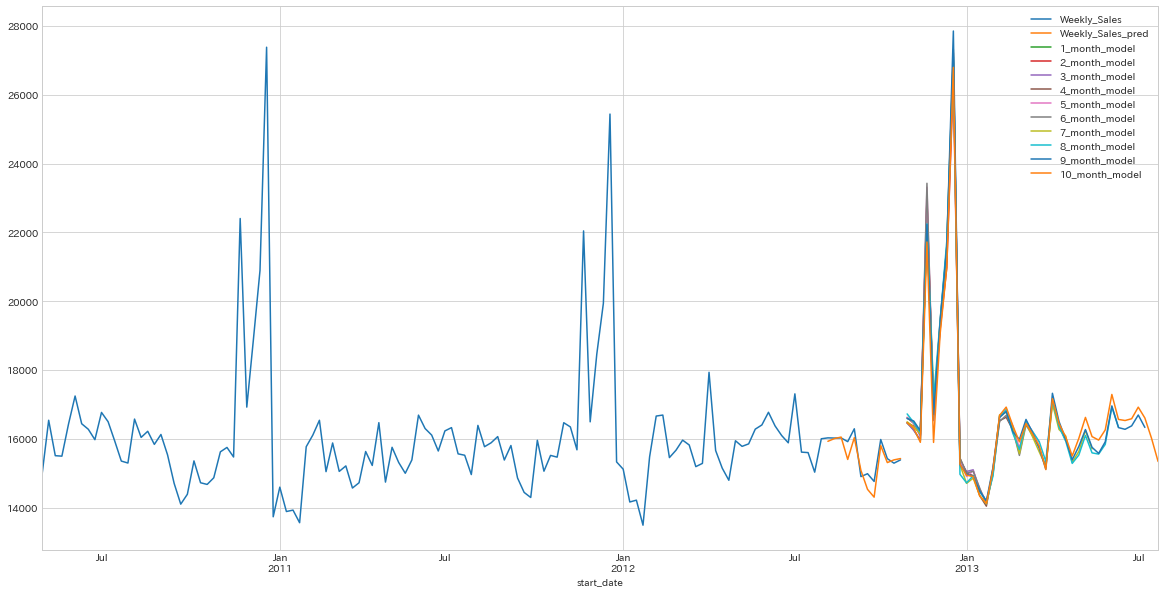

In [28]:
train_df = pd.read_pickle(f'../output/{model_name}/result/1month_train.pkl')[
    ['Store', 'Dept', 'start_date', 'Weekly_Sales', 'Weekly_Sales_pred_fold0', 'Weekly_Sales_pred_fold1', 'Weekly_Sales_pred_fold2']
]
train_df['Weekly_Sales_pred'] = train_df[[col for col in train_df.columns if 'pred' in col]].mean(1)
ax = train_df.groupby('start_date')[['Weekly_Sales', 'Weekly_Sales_pred']].mean().plot(figsize=(20, 10))
result_df = pd.read_pickle(f'../output/{model_name}/result/10month_test.pkl')[['Store', 'Dept', 'start_date']]
for i in range(1, 11):
    test_df = pd.read_pickle(f'../output/{model_name}/result/{i}month_test.pkl')[['Store', 'Dept', 'start_date', 'Weekly_Sales']]
    test_df.groupby('start_date')['Weekly_Sales'].mean().plot(ax=ax, label=f'{i}_month_model')
    test_df = test_df.rename(columns={'Weekly_Sales': f'Weekly_Sales_{i}month'})
    result_df = result_df.merge(test_df, on=['Store', 'Dept', 'start_date'], how='left')
ax.legend()

In [29]:
result_df['id'] = result_df['Store'].astype('str') + '_' + result_df['Dept'].astype('str')+ '_' + result_df['start_date'].astype('str')

In [30]:
result_df['null_count'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].notnull().sum(1)
result_df['Weekly_Sales'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].sum(1) / result_df['null_count']
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_mean_v3.csv', index=False)

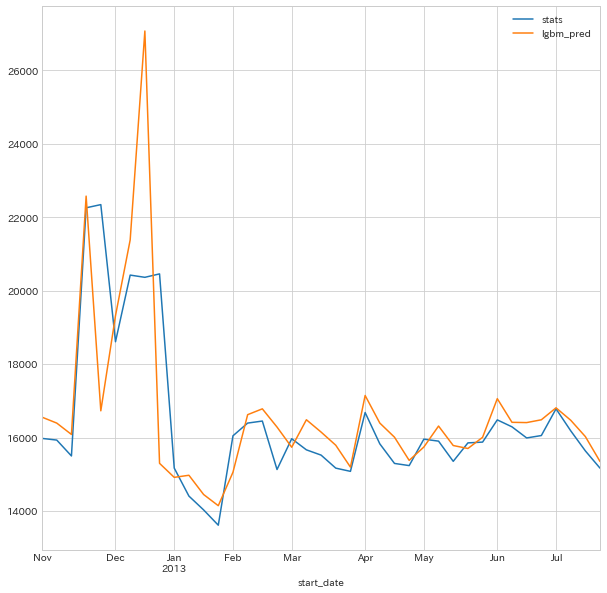

In [31]:
stats_df = pd.read_csv(f'../output/stats.csv')
stats_df['start_date'] = pd.to_datetime(stats_df['id'].apply(lambda x: x.split('_')[-1]), infer_datetime_format=True)
ax = stats_df.groupby('start_date')['Weekly_Sales'].mean().plot(figsize=(10, 10), label='stats')
result_df.groupby('start_date')['Weekly_Sales'].mean().plot(ax=ax, label='lgbm_pred')
ax.legend()

In [32]:
result_df['month'] = result_df['start_date'].dt.month

In [33]:
result_df = result_df.sort_values('id').reset_index(drop=True)
stats_df = stats_df.sort_values('id').reset_index(drop=True)
# index = result_df.query('1 <= month < 3 | 11 <= month').index
# result_df.loc[index, 'Weekly_Sales'] = (result_df.loc[index, 'Weekly_Sales'] + stats_df.loc[index, 'Weekly_Sales']) / 2
result_df['Weekly_Sales'] = (result_df['Weekly_Sales'] + stats_df['Weekly_Sales']) / 2

In [34]:
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_mean_v3_stats_ens.csv', index=False)

## version4 (normalizeした売り上げ特徴追加)

In [35]:
model_name = 'add_norm_feature'

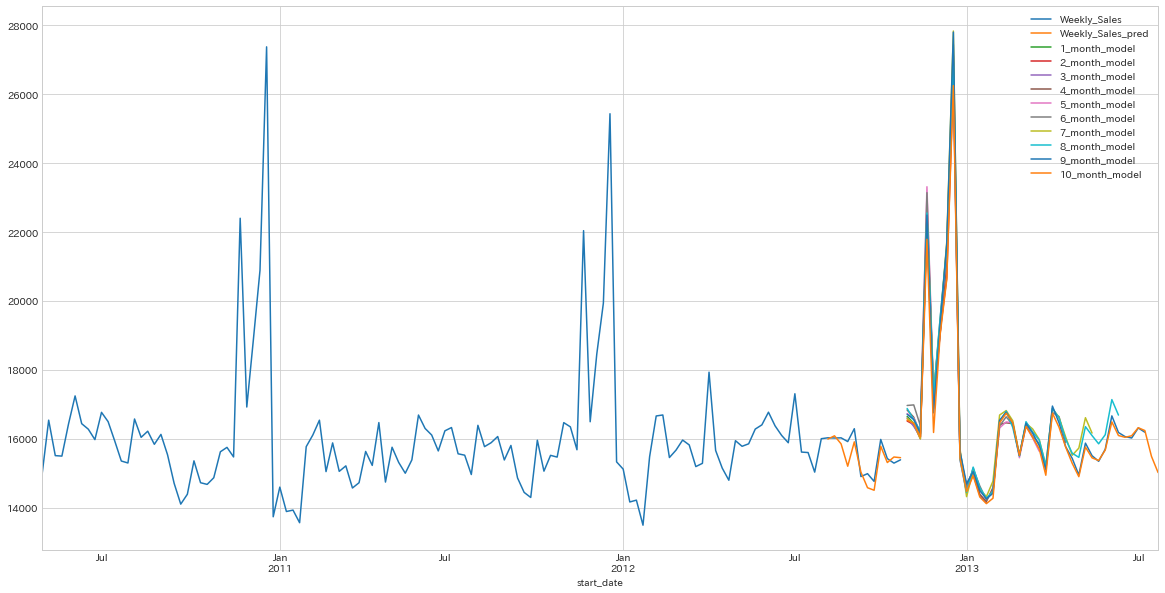

In [36]:
train_df = pd.read_pickle(f'../output/{model_name}/result/1month_train.pkl')[
    ['Store', 'Dept', 'start_date', 'Weekly_Sales', 'Weekly_Sales_pred_fold0', 'Weekly_Sales_pred_fold1', 'Weekly_Sales_pred_fold2']
]
train_df['Weekly_Sales_pred'] = train_df[[col for col in train_df.columns if 'pred' in col]].mean(1)
ax = train_df.groupby('start_date')[['Weekly_Sales', 'Weekly_Sales_pred']].mean().plot(figsize=(20, 10))
result_df = pd.read_pickle(f'../output/{model_name}/result/10month_test.pkl')[['Store', 'Dept', 'start_date']]
for i in range(1, 11):
    test_df = pd.read_pickle(f'../output/{model_name}/result/{i}month_test.pkl')[['Store', 'Dept', 'start_date', 'Weekly_Sales']]
    test_df.groupby('start_date')['Weekly_Sales'].mean().plot(ax=ax, label=f'{i}_month_model')
    test_df = test_df.rename(columns={'Weekly_Sales': f'Weekly_Sales_{i}month'})
    result_df = result_df.merge(test_df, on=['Store', 'Dept', 'start_date'], how='left')
ax.legend()

In [37]:
result_df['id'] = result_df['Store'].astype('str') + '_' + result_df['Dept'].astype('str')+ '_' + result_df['start_date'].astype('str')
result_df['null_count'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].notnull().sum(1)
result_df['Weekly_Sales'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].sum(1) / result_df['null_count']
result_df[['id', 'Weekly_Sales']].to_csv('../output/split_baseline_mean_v4.csv', index=False)

### アンサンブル

In [38]:
def load_result(model_name: str) -> pd.DataFrame:
    result_df = pd.read_pickle(f'../output/{model_name}/result/10month_test.pkl')[['Store', 'Dept', 'start_date']]
    for i in range(1, 11):
        test_df = pd.read_pickle(f'../output/{model_name}/result/{i}month_test.pkl')[['Store', 'Dept', 'start_date', 'Weekly_Sales']]
        test_df = test_df.rename(columns={'Weekly_Sales': f'Weekly_Sales_{i}month'})
        result_df = result_df.merge(test_df, on=['Store', 'Dept', 'start_date'], how='left')
    result_df['id'] = result_df['Store'].astype('str') + '_' + result_df['Dept'].astype('str')+ '_' + result_df['start_date'].astype('str')
    result_df['null_count'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].notnull().sum(1)
    result_df['Weekly_Sales'] = result_df[[f'Weekly_Sales_{i}month' for i in range(1, 11)]].sum(1) / result_df['null_count']
    result_df = postprocess_v2(result_df)
    result_df = result_df.sort_values('id').reset_index(drop=True)
    return result_df

In [39]:
model_names = ['add_lag_feature', 'add_norm_feature_lr001']
dfs = [load_result(model_name) for model_name in model_names]

In [40]:
dfs[0]['Weekly_Sales'] = np.mean([df['Weekly_Sales'].values for df in dfs], axis=0)

In [41]:
dfs[0][['id', 'Weekly_Sales']].to_csv('../output/ensemble_v2_v4.csv', index=False)

In [42]:
stats_df = pd.read_csv(f'../output/stats.csv')
stats_df = stats_df.sort_values('id').reset_index(drop=True)
dfs = [load_result(model_name) for model_name in model_names]

In [43]:
dfs[0]['Weekly_Sales'] = np.mean([df['Weekly_Sales'].values for df in dfs + [stats_df]], axis=0)

In [44]:
dfs[0][['id', 'Weekly_Sales']].to_csv('../output/ensemble_v2_v4_stats.csv', index=False)